<a href="https://colab.research.google.com/github/pachterlab/CP_2023/blob/main/notebooks/bMCML/kimetal_smartseq_bmcml_l1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

bMCML analysis with L1 norm

In [ ]:
import requests
import os

from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname


#10x VMH data
#metadata.csv
download_file('10.22002/D1.2067','.gz')

#smartseq.mtx (log counts)
download_file('10.22002/D1.2071','.gz')



os.system("gunzip *.gz")

os.system("mv D1.2067 metadata.csv")
os.system("mv D1.2071 smartseq.mtx")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/64 [00:00<?, ?B/s]

  0%|          | 0/26700 [00:00<?, ?B/s]

0

In [ ]:
!git clone https://github.com/hhcho/densvis.git

Cloning into 'densvis'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 145 (delta 3), reused 2 (delta 2), pack-reused 137
Receiving objects: 100% (145/145), 419.61 KiB | 3.11 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [ ]:
%cd /content/densvis/densne/

/content/densvis/densne


In [ ]:
!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient accuracy
   ~~~~~^~~~~~~~~~

In [ ]:
%cd /content/

/content


In [ ]:
!git clone https://github.com/pachterlab/CP_2023.git

Cloning into 'CP_2022'...
remote: Enumerating objects: 688, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 688 (delta 148), reused 244 (delta 136), pack-reused 424
Receiving objects: 100% (688/688), 247.06 MiB | 28.22 MiB/s, done.
Resolving deltas: 100% (361/361), done.
Checking out files: 100% (81/81), done.


In [ ]:
%cd /content/CP_2023/scripts

/content/CP_2022/scripts


In [ ]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy

     |████████████████████████████████| 96 kB 2.8 MB/s 
     |████████████████████████████████| 7.7 MB 3.9 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 88 kB 6.0 MB/s 
     |████████████████████████████████| 1.1 MB 59.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 


## **Install Packages**

In [ ]:
import anndata
import pandas as pd
import numpy as np
from MCML import MCML, bMCML #Now has continuous label addition
import visualizations as vis
import tools as tl
from Picasso import Picasso
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
sns.set_style('white')

## **Import Data**

In [ ]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '/content'

pcs = 50
n_latent = 50

In [ ]:
count_mat = sio.mmread(data_path+'/smartseq.mtx')
count_mat.shape

(3850, 1999)

In [ ]:
#Center and scale log-normalized data
scaled_mat = scale(count_mat)

In [ ]:
meta = pd.read_csv(data_path+'/metadata.csv',index_col = 0)
meta.head()

,sample_name,smartseq_cluster_id,smartseq_cluster,sex_label,smartseq_cluster_color,medical_cond_label,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter
SM-GE4R2_S062_E1-50,SM-GE4R2_S062_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,964371.56,9772,0.0,True,True
SM-GE4SI_S356_E1-50,SM-GE4SI_S356_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,973072.06,8253,0.0,True,True
SM-GE4SI_S172_E1-50,SM-GE4SI_S172_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,977132.60,9394,0.0,True,True
LS-15034_S07_E1-50,LS-15034_S07_E1-50,42,Nr5a1_4|7 Glipr1,M,#763BFF,behavior - none,948605.44,10643,0.0,True,True
LS-15034_S28_E1-50,LS-15034_S28_E1-50,42,Nr5a1_4|7 Glipr1,F,#763BFF,behavior - none,951803.00,10550,0.0,True,True


In [ ]:
print(meta.sex_label.value_counts()[0]/meta.sex_label.value_counts()[1])
print(meta.sex_label.value_counts()[1])

7.406113537117904
458


In [ ]:
lab1 = list(meta.smartseq_cluster)
lab2 = list(meta.sex_label)
lab3 = list(meta.medical_cond_label)


allLabs = np.array([lab1,lab2])

nanLabs = np.array([[np.nan]*len(lab1)])

#Shuffled labels for over-fitting check
shuff_lab1 = random.sample(lab1, len(lab1))
shuff_lab2 = random.sample(lab2, len(lab2))
shuff_allLabs = np.array([shuff_lab1,shuff_lab2])

clus_colors = list(pd.unique(meta.smartseq_cluster_color))

sex_colors = ['#abacb7','#F8C471']

Set Ambient Data

In [ ]:
amb = tl.getCentroidDists(count_mat,meta.smartseq_cluster,m='l1')
ambIntra = tl.getIntraVar(count_mat, meta.smartseq_cluster, meta.sex_label,m='l1')
ambIntraC = tl.getIntraVar(count_mat, meta.smartseq_cluster, meta.smartseq_cluster,m='l1')
ambInter = tl.getInterVar(count_mat, meta.smartseq_cluster, meta.sex_label,m='l1')

In [ ]:
def getAllVars(latents,latentLab,latentType):
  emb = []

  vals = []

  dist = []

  dim = []

  allVals = pd.DataFrame()

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]
    d = latentType[p]

    c = tl.getCentroidDists(i, meta.smartseq_cluster,m='l1')
    intra = tl.getIntraVar(i, meta.smartseq_cluster, meta.sex_label,m='l1')
    intraC = tl.getIntraVar(i, meta.smartseq_cluster, meta.smartseq_cluster,m='l1')
    inter = tl.getInterVar(i, meta.smartseq_cluster, meta.sex_label,m='l1')

    vals += [stats.pearsonr(c, amb)[0],stats.pearsonr(intra, ambIntra)[0], stats.pearsonr(intraC, ambIntraC)[0], stats.pearsonr(inter, ambInter)[0]]
    dist += ['Inter-Type','Intra-Sex','Intra-Type','Inter-Sex']

    emb += [l]*4
    dim += [d]*4


  allVals['Latent'] = emb
  allVals['Distance'] = dist
  allVals['Pearsonr'] = vals
  allVals['Dimension'] = dim


  return allVals


In [ ]:
# orig_indices = tl.getNeighbors(count_mat, n_neigh = 10,p=2)

In [ ]:
def getJac(orig_indices,latents, latentLab, n_neighbors=30,set_p=1):
  emb = []

  xs = []

  ys = []

  knnDF = pd.DataFrame()

  for p in range(len(latents)):
    i = latents[p]
    l = latentLab[p]

    ind = tl.getNeighbors(i, n_neigh = n_neighbors,p=set_p)

    x = tl.getJaccard(orig_indices,ind)

    xs += x
    #ys += list(y)

    emb += [l]*len(x)

    print(l)

    print(np.mean(tl.getJaccard(orig_indices,ind)))



  knnDF['x'] = xs
  #knnDF['y'] = ys
  knnDF['latent'] = emb

  return knnDF

In [ ]:
# def getAllKNNs(latents,latentLab,latentType):
#   emb = []

#   frac = []


#   knnDF = pd.DataFrame()

#   for p in range(len(latents)):
#     i = latents[p]
#     l = latentLab[p]

#     ind = tl.getNeighbors(i, n_neigh = 10,p=1)

#     frac += [np.mean(tl.getIntersect(orig_indices,ind))]



#     emb += [l]


#   knnDF['Fraction'] = frac
#   knnDF['Latent'] = emb

#   return knnDF

### **Biased Reconstruction MCML**

In [ ]:
rounds = 3

In [ ]:
#Test with only gender labels (intra-var for gender)
gen = []
genLab = []
genType = []


for i in range(rounds):
  nca = bMCML(n_latent = 50, epochs = 500,batch_size = 200) #400
  lossesGen, latentGen = nca.fit(count_mat,allLabs[0],allLabs[1], silent=True,ret_loss=True, p=1.0) #SWITCH TO count_mat

  gen += [latentGen]
  genLab += ['Intra-Sex MCML']
  genType += ['MCML 50D']



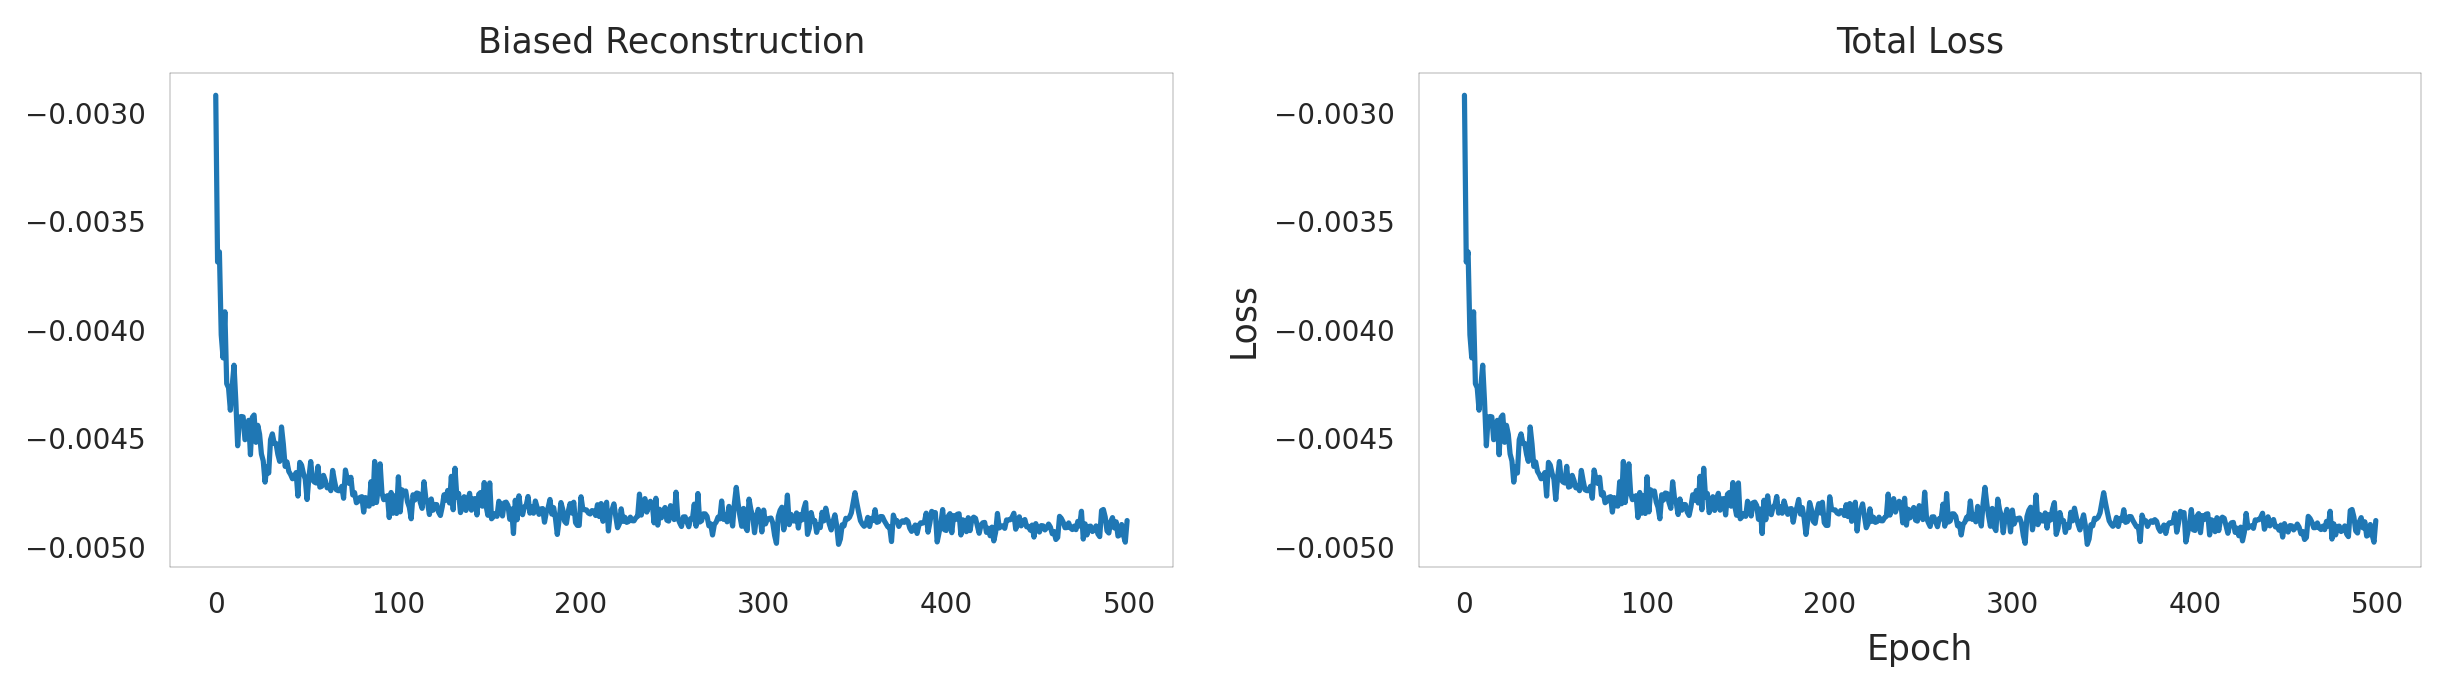

In [ ]:
#sexloss
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

In [ ]:
#Test with only type labels (intra-var for type)
typ = []
typLab = []
typType = []

for i in range(rounds):
  nca = bMCML(n_latent = 50, epochs = 500, batch_size = 200)
  lossesType, latentType = nca.fit(count_mat,allLabs[0],allLabs[0], silent=True,ret_loss=True,p=1.0) #SWITCH TO count_mat

  typ += [latentType]
  typLab += ['Intra-Type MCML']
  typType += ['MCML 50D']

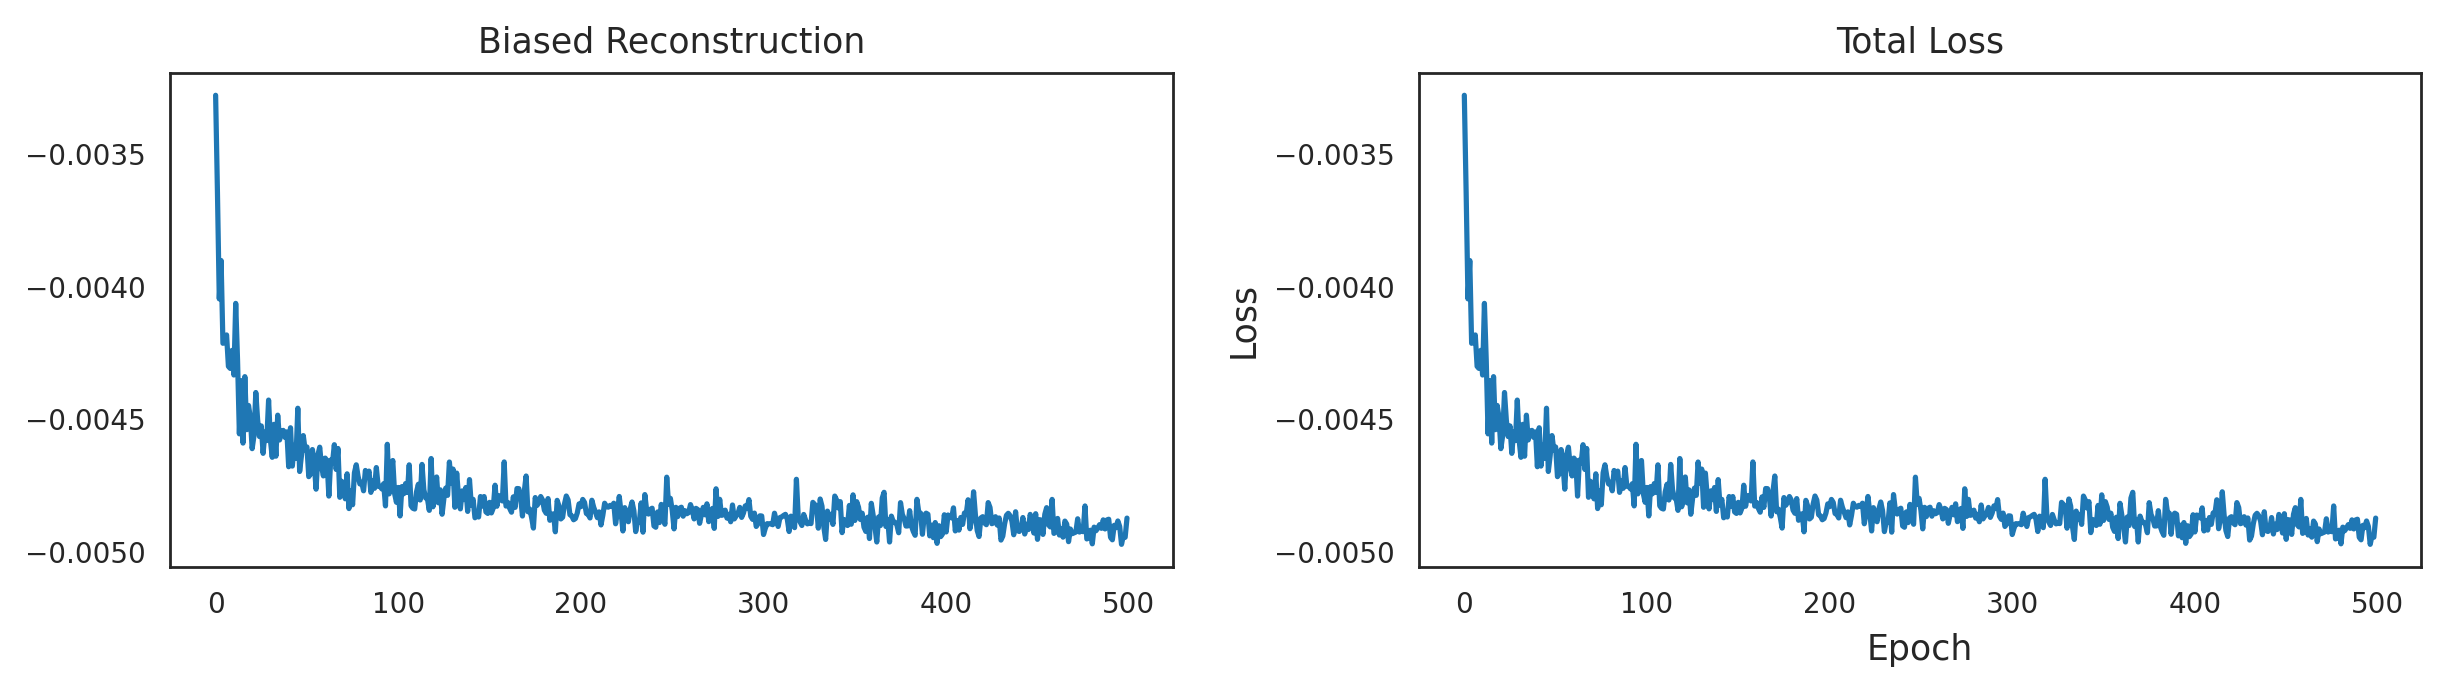

In [ ]:
#Type Loss
nca.plotLosses(figsize=(10,3),axisFontSize=10,tickFontSize=8)

Get Latent Spaces for Comparison (baselines)

In [ ]:
def reconComp(scaled_mat, ndims=2, pcs=50, rounds = 3):
	""" Compute latent space representations as baseline for reconstruction abilities
	scaled_mat : Numpy array of latent space (n_obs x n_latent)
	ndims : No. of dimensions to reduce scaled_mat to
	pcs : No. of PCs to use
	rounds : No. of rounds to replicate over
	Returns:
	latents : List containing each generated latent space
	latentLab : List containing label for each latent space
	latentType : List containing broad category label for each latent space
	"""

	latents = []
	latentLab = []
	latentType = []

	nanLabs = np.array([[np.nan]*scaled_mat.shape[0]])

	for i in range(rounds):
		tsvd = TruncatedSVD(n_components=pcs)
		x_pca = tsvd.fit_transform(scaled_mat)

		tsvd = TruncatedSVD(n_components=2)
		x_pca_2d = tsvd.fit_transform(scaled_mat)

		# tsne = TSNE(n_components = pcs,method='exact')
		# pcaTSNE = tsne.fit_transform(scaled_mat)

		reducer = umap.UMAP(n_components = pcs)
		pcaUMAP = reducer.fit_transform(count_mat)


		densUMAP = umap.UMAP(n_components = pcs,densmap=True)
		pcaDensUMAP = densUMAP.fit_transform(count_mat)

		# pcaDensTSNE, ro ,re = densne.run_densne(scaled_mat,no_dims = pcs)


		#MCML runs
		ncaR = MCML(n_latent = pcs, epochs = 100)

		lossesR, latentR = ncaR.fit(scaled_mat,nanLabs,fracNCA = 0, silent = True,ret_loss = True)

		latents += [latentR, x_pca, x_pca_2d, pcaDensUMAP,pcaUMAP ]
		latentLab += ['Recon MCML 50D','PCA 50D','PCA 2D','densMap 50D','UMAP 50D']
		latentType += ['50D','50D','2D','50D','50D']

	return latents,latentLab,latentType

In [ ]:
latents,latentLab,latentType = reconComp(scaled_mat, ndims=2, pcs=50)

Compare Gender Corr Reconstruction Embedding Accuracy

In [ ]:
latentLab

['Intra-Type MCML',
 'Intra-Type MCML',
 'Intra-Type MCML',
 'Intra-Sex MCML',
 'Intra-Sex MCML',
 'Intra-Sex MCML',
 'Recon MCML 50D',
 'PCA 50D',
 'PCA 2D',
 'densMap 50D',
 'UMAP 50D',
 'Recon MCML 50D',
 'PCA 50D',
 'PCA 2D',
 'densMap 50D',
 'UMAP 50D',
 'Recon MCML 50D',
 'PCA 50D',
 'PCA 2D',
 'densMap 50D',
 'UMAP 50D']

In [ ]:
latents = gen + latents

latentLab = genLab + latentLab

latentType = genType + latentType

In [ ]:
allVals = getAllVars(latents,latentLab,latentType)
#allVals = allVals[~allVals['Latent'].isin(['PCA 2D'])]

In [ ]:
pca = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['PCA 50D']) & allVals['Distance'].isin(['Intra-Sex'])])
recon = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['Recon MCML 50D']) & allVals['Distance'].isin(['Intra-Sex'])])
intraSex = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['Intra-Sex MCML']) & allVals['Distance'].isin(['Intra-Sex'])])

print((intraSex-pca)/pca)
print((intraSex-recon)/recon)

2.0762451890846827
2.1277485253013424


In [ ]:
allVals.head()

,Latent,Distance,Pearsonr,Dimension
0,Intra-Sex MCML,Inter-Type,0.821242,MCML 50D
1,Intra-Sex MCML,Intra-Sex,0.971910,MCML 50D
2,Intra-Sex MCML,Intra-Type,0.989227,MCML 50D
3,Intra-Sex MCML,Inter-Sex,0.956680,MCML 50D
4,Intra-Sex MCML,Inter-Type,0.862069,MCML 50D


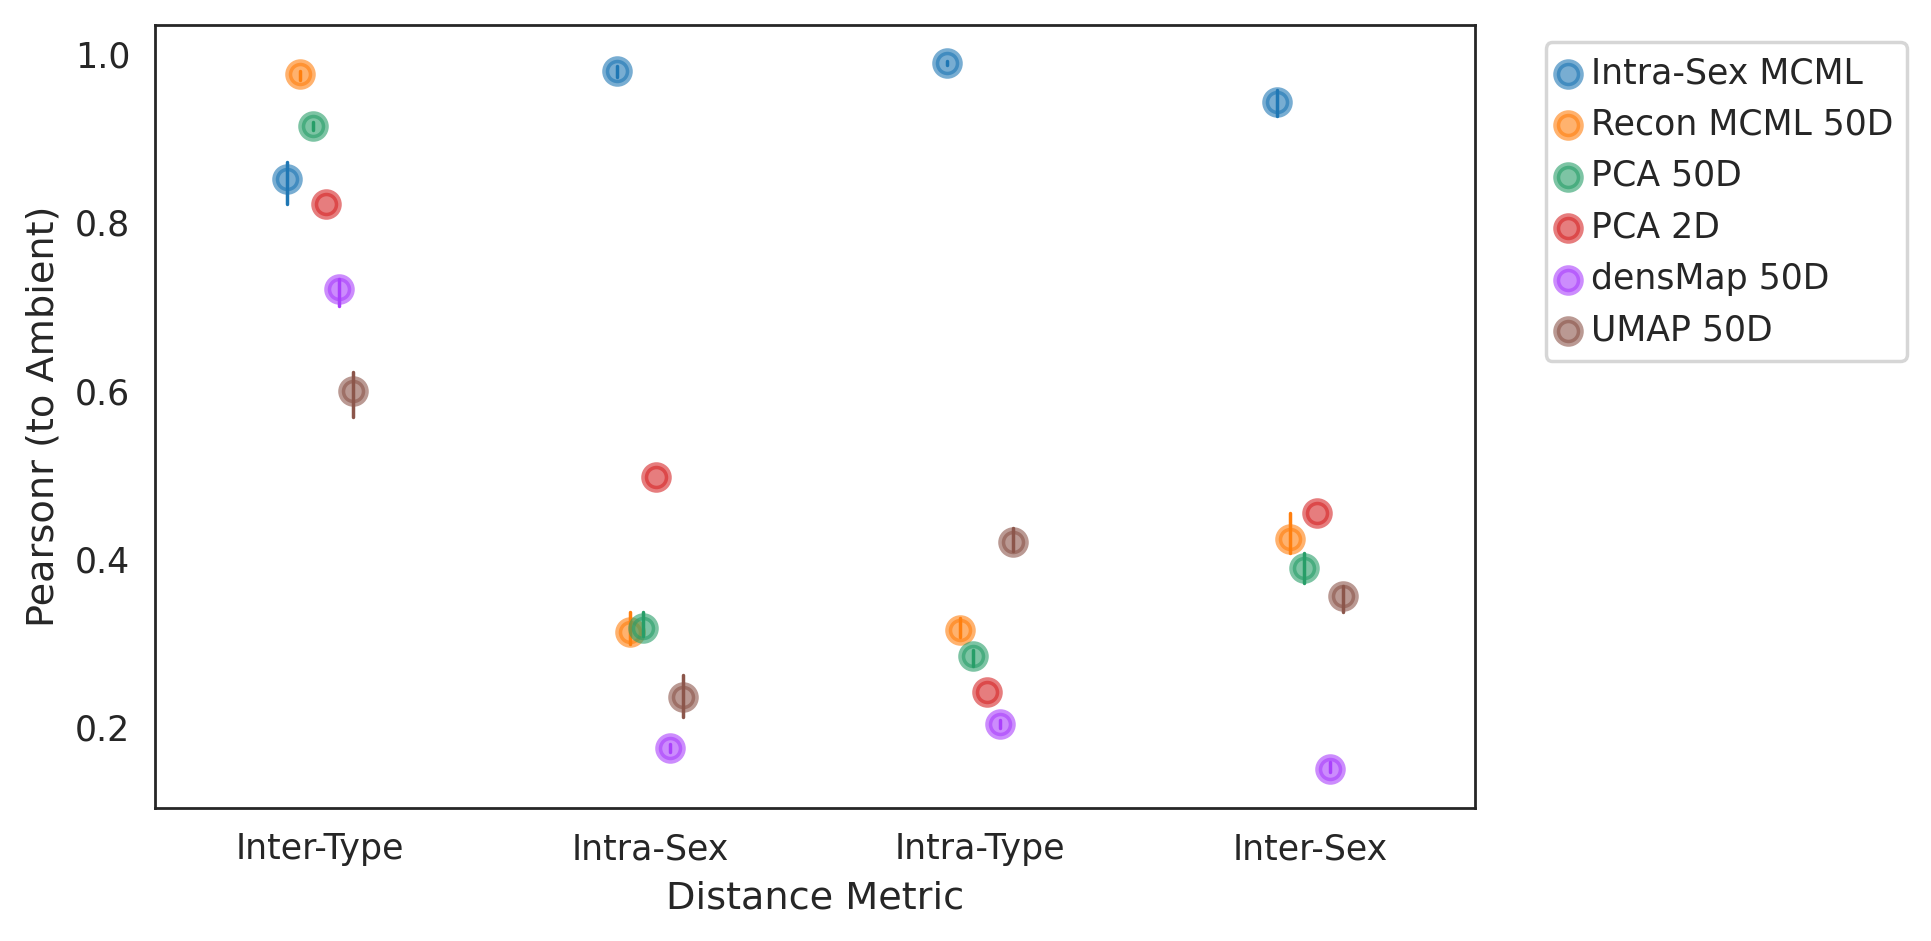

In [ ]:
vis.plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, dodge=0.2, fname = None)

In [ ]:

from google.colab import files

allVals.to_csv('intraSex.csv')
files.download('intraSex.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Compare Type Corr Reconstruction Embedding Accuracy

In [ ]:
latents = typ + latents

latentLab = typLab + latentLab

latentType = typType + latentType

In [ ]:
allVals = getAllVars(latents,latentLab,latentType)
allVals = allVals[~allVals['Latent'].isin(['Intra-Sex MCML'])]

In [ ]:
pca = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['PCA 50D']) & allVals['Distance'].isin(['Intra-Type'])])
recon = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['Recon MCML 50D']) & allVals['Distance'].isin(['Intra-Type'])])
intraType = np.mean(allVals['Pearsonr'][allVals['Latent'].isin(['Intra-Type MCML']) & allVals['Distance'].isin(['Intra-Type'])])

print((intraType-pca)/pca)
print((intraType-recon)/recon)

2.448466661947228
2.113801421713611


In [ ]:
allVals.head()

,Latent,Distance,Pearsonr,Dimension
0,Intra-Type MCML,Inter-Type,0.868703,MCML 50D
1,Intra-Type MCML,Intra-Sex,0.962510,MCML 50D
2,Intra-Type MCML,Intra-Type,0.980556,MCML 50D
3,Intra-Type MCML,Inter-Sex,0.981447,MCML 50D
4,Intra-Type MCML,Inter-Type,0.869456,MCML 50D


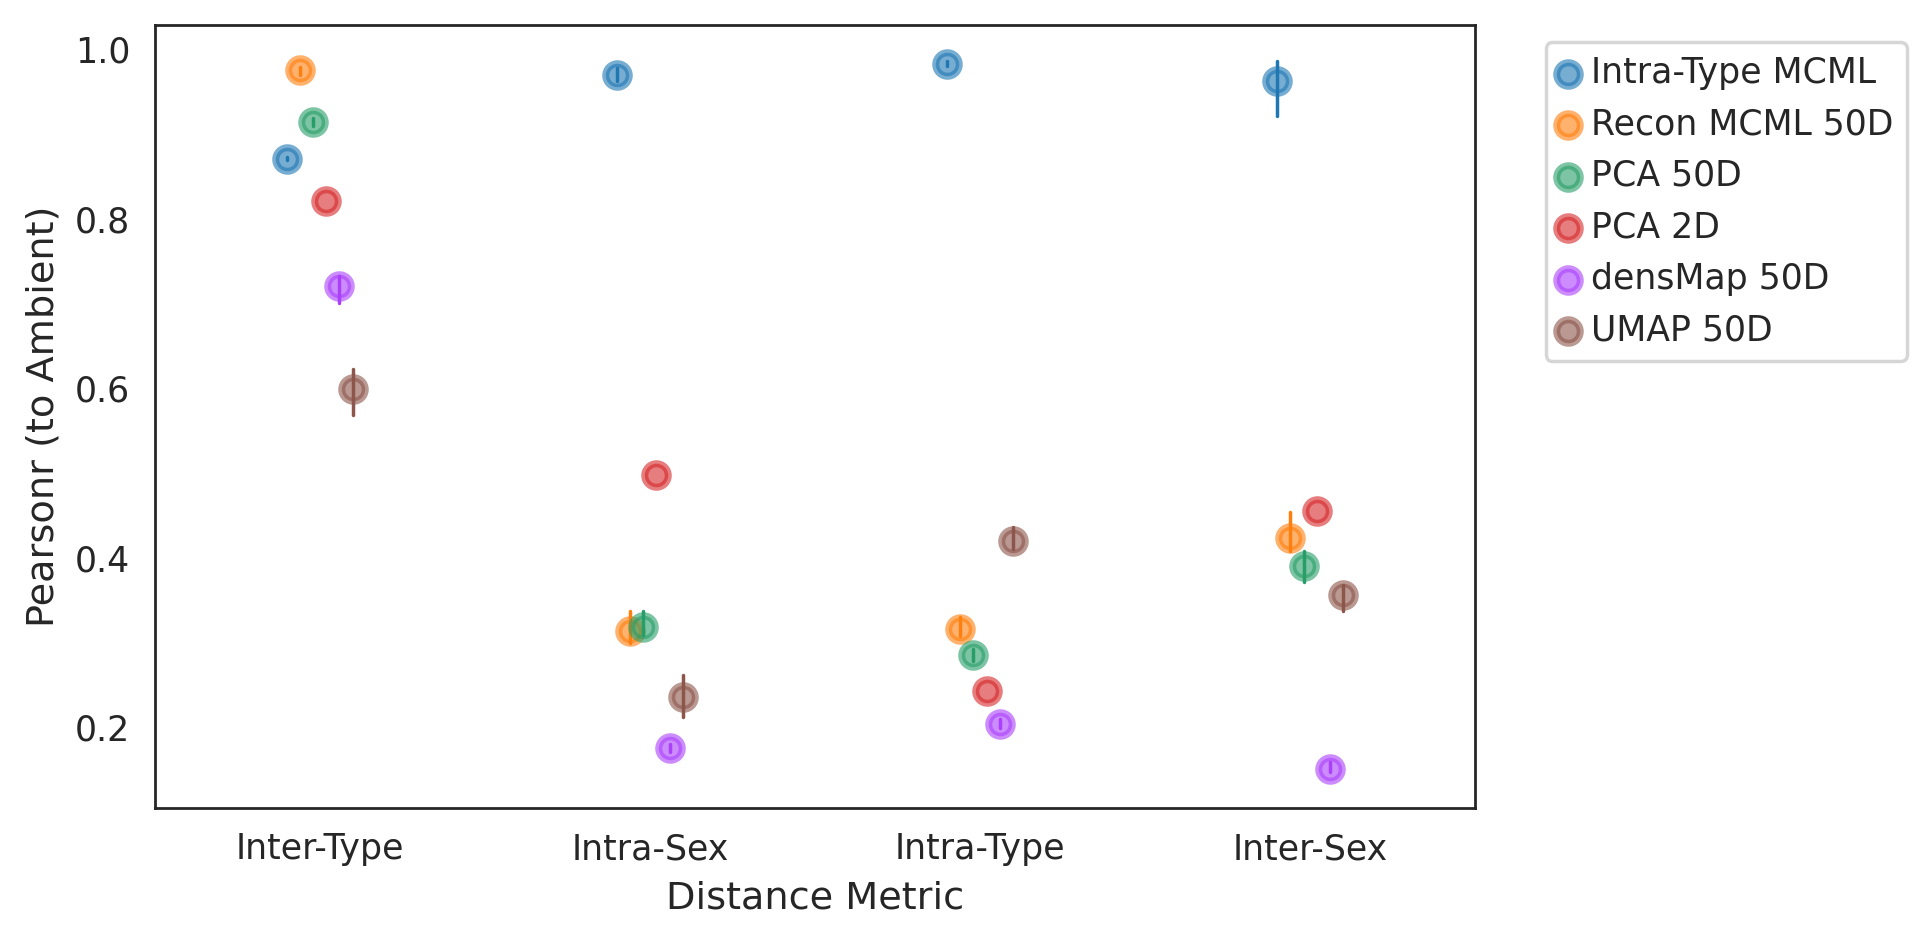

In [ ]:
vis.plotLatentStats(allVals, axisFontSize = 11, tickFontSize = 10, dodge=0.2, fname = None)

In [ ]:

from google.colab import files

allVals.to_csv('intraType.csv')
files.download('intraType.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>